In [1]:
import numpy as np
import os
from scipy import ndarray

import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import imageio
import cv2

from numpy import linalg as LA
from scipy.sparse import csc_matrix,coo_matrix
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import PCA,TruncatedSVD
import pickle
import pandas as pd
from random import randint
import random

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AffinityPropagation, MeanShift
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from scipy import ndimage
import imageio

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    
def embedding(data,dim):
    projection = mapper.fit_transform(data, projection=umap.UMAP(n_components=dim, n_neighbors=200, 
                                             a=None, angular_rp_forest=False, b=None, init='spectral',
                                           learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
                                           metric_kwds=None, min_dist=0.1, n_epochs=500,
                                           negative_sample_rate=10, random_state=47,
                                           repulsion_strength=1.0, set_op_mix_ratio=0.5, spread=0.25,
                                           target_metric='categorical', target_metric_kwds=None,
                                           target_n_neighbors=-1, target_weight=0.5, transform_queue_size=10.0,
                                           transform_seed=42, verbose=False))
    return projection

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

import math

def round_up_to_even(f):
    return int(math.ceil(f / 2.) * 2)

In [5]:
directory = '/home/garner1/Work/dataset/cellImages/image52/Nuclei_Image52'
Mwidths = 60
Mheights = 60
images = []
cell_id = []

count = 1
while count <= 1699: # use this loop form to make sure that cell_id are presersed
    cell = str(count)+'.jpg'
    filename = os.path.join(directory, cell)
    img = imageio.imread(filename)
    rmin, rmax, cmin, cmax = bbox(img)
    delta_w, delta_h = Mwidths-(rmax-rmin), Mheights-(cmax-cmin)
    if delta_w >= 0 and delta_h >= 0:
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        newimg = np.pad(img[rmin:rmax,cmin:cmax],((left,right),(top,bottom)),'constant', constant_values=(0))
        images.append(newimg)
        cell_id.append(count)
    else:
        print(filename+' has a problem!')
    count += 1

In [6]:
import csv
with open('/home/garner1/Work/dataset/cellImages/image52/properties.csv', 'r') as f:
    properties = list(csv.reader(f, delimiter=','))
XY = np.array(properties)[1:,1:3].astype(np.float)
print(XY.shape)

(1699, 2)


In [7]:
X = np.zeros((len(images),Mwidths*Mheights))
for ind in range(len(images)):
    X[ind,:] = images[ind].flatten() # from 2D arrays to 1D arrays
print(X.shape)

(1699, 3600)


In [8]:
'''2D embedding'''
n_neighbors = 20

'''
Returns
-------
fuzzy_simplicial_set: coo_matrix
A fuzzy simplicial set represented as a sparse matrix. The 
(i,j) entry of the matrix represents the membership strength of the
1-simplex between the ith and jth sample points.
'''
mat_X = umap.umap_.fuzzy_simplicial_set(
    X,
    n_neighbors,
    random_state=np.random.RandomState(seed=42),
    metric='euclidean',
    metric_kwds={},
    knn_indices=None,
    knn_dists=None,
    angular=False,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    verbose=False
)

mat_XY = umap.umap_.fuzzy_simplicial_set(
    XY,
    n_neighbors,
    random_state=np.random.RandomState(seed=42),
    metric='euclidean',
    metric_kwds={},
    knn_indices=None,
    knn_dists=None,
    angular=False,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    verbose=False
)

In [9]:
newX = mat_X+min(mat_X.data)*np.ones(mat_X.shape)  # make mat dense otherwise hada is too sparse
newXY = mat_XY+min(mat_XY.data)*np.ones(mat_XY.shape)
hada = np.log10(np.multiply(newX,newXY))
hada = hada-hada.min()
# hada = mat_X+mat_XY
# print(hada.shape,len(mat_X.data),len(mat_XY.data))
print(hada.max(),hada.min())

8.06596388584273 0.0


KeyboardInterrupt: 

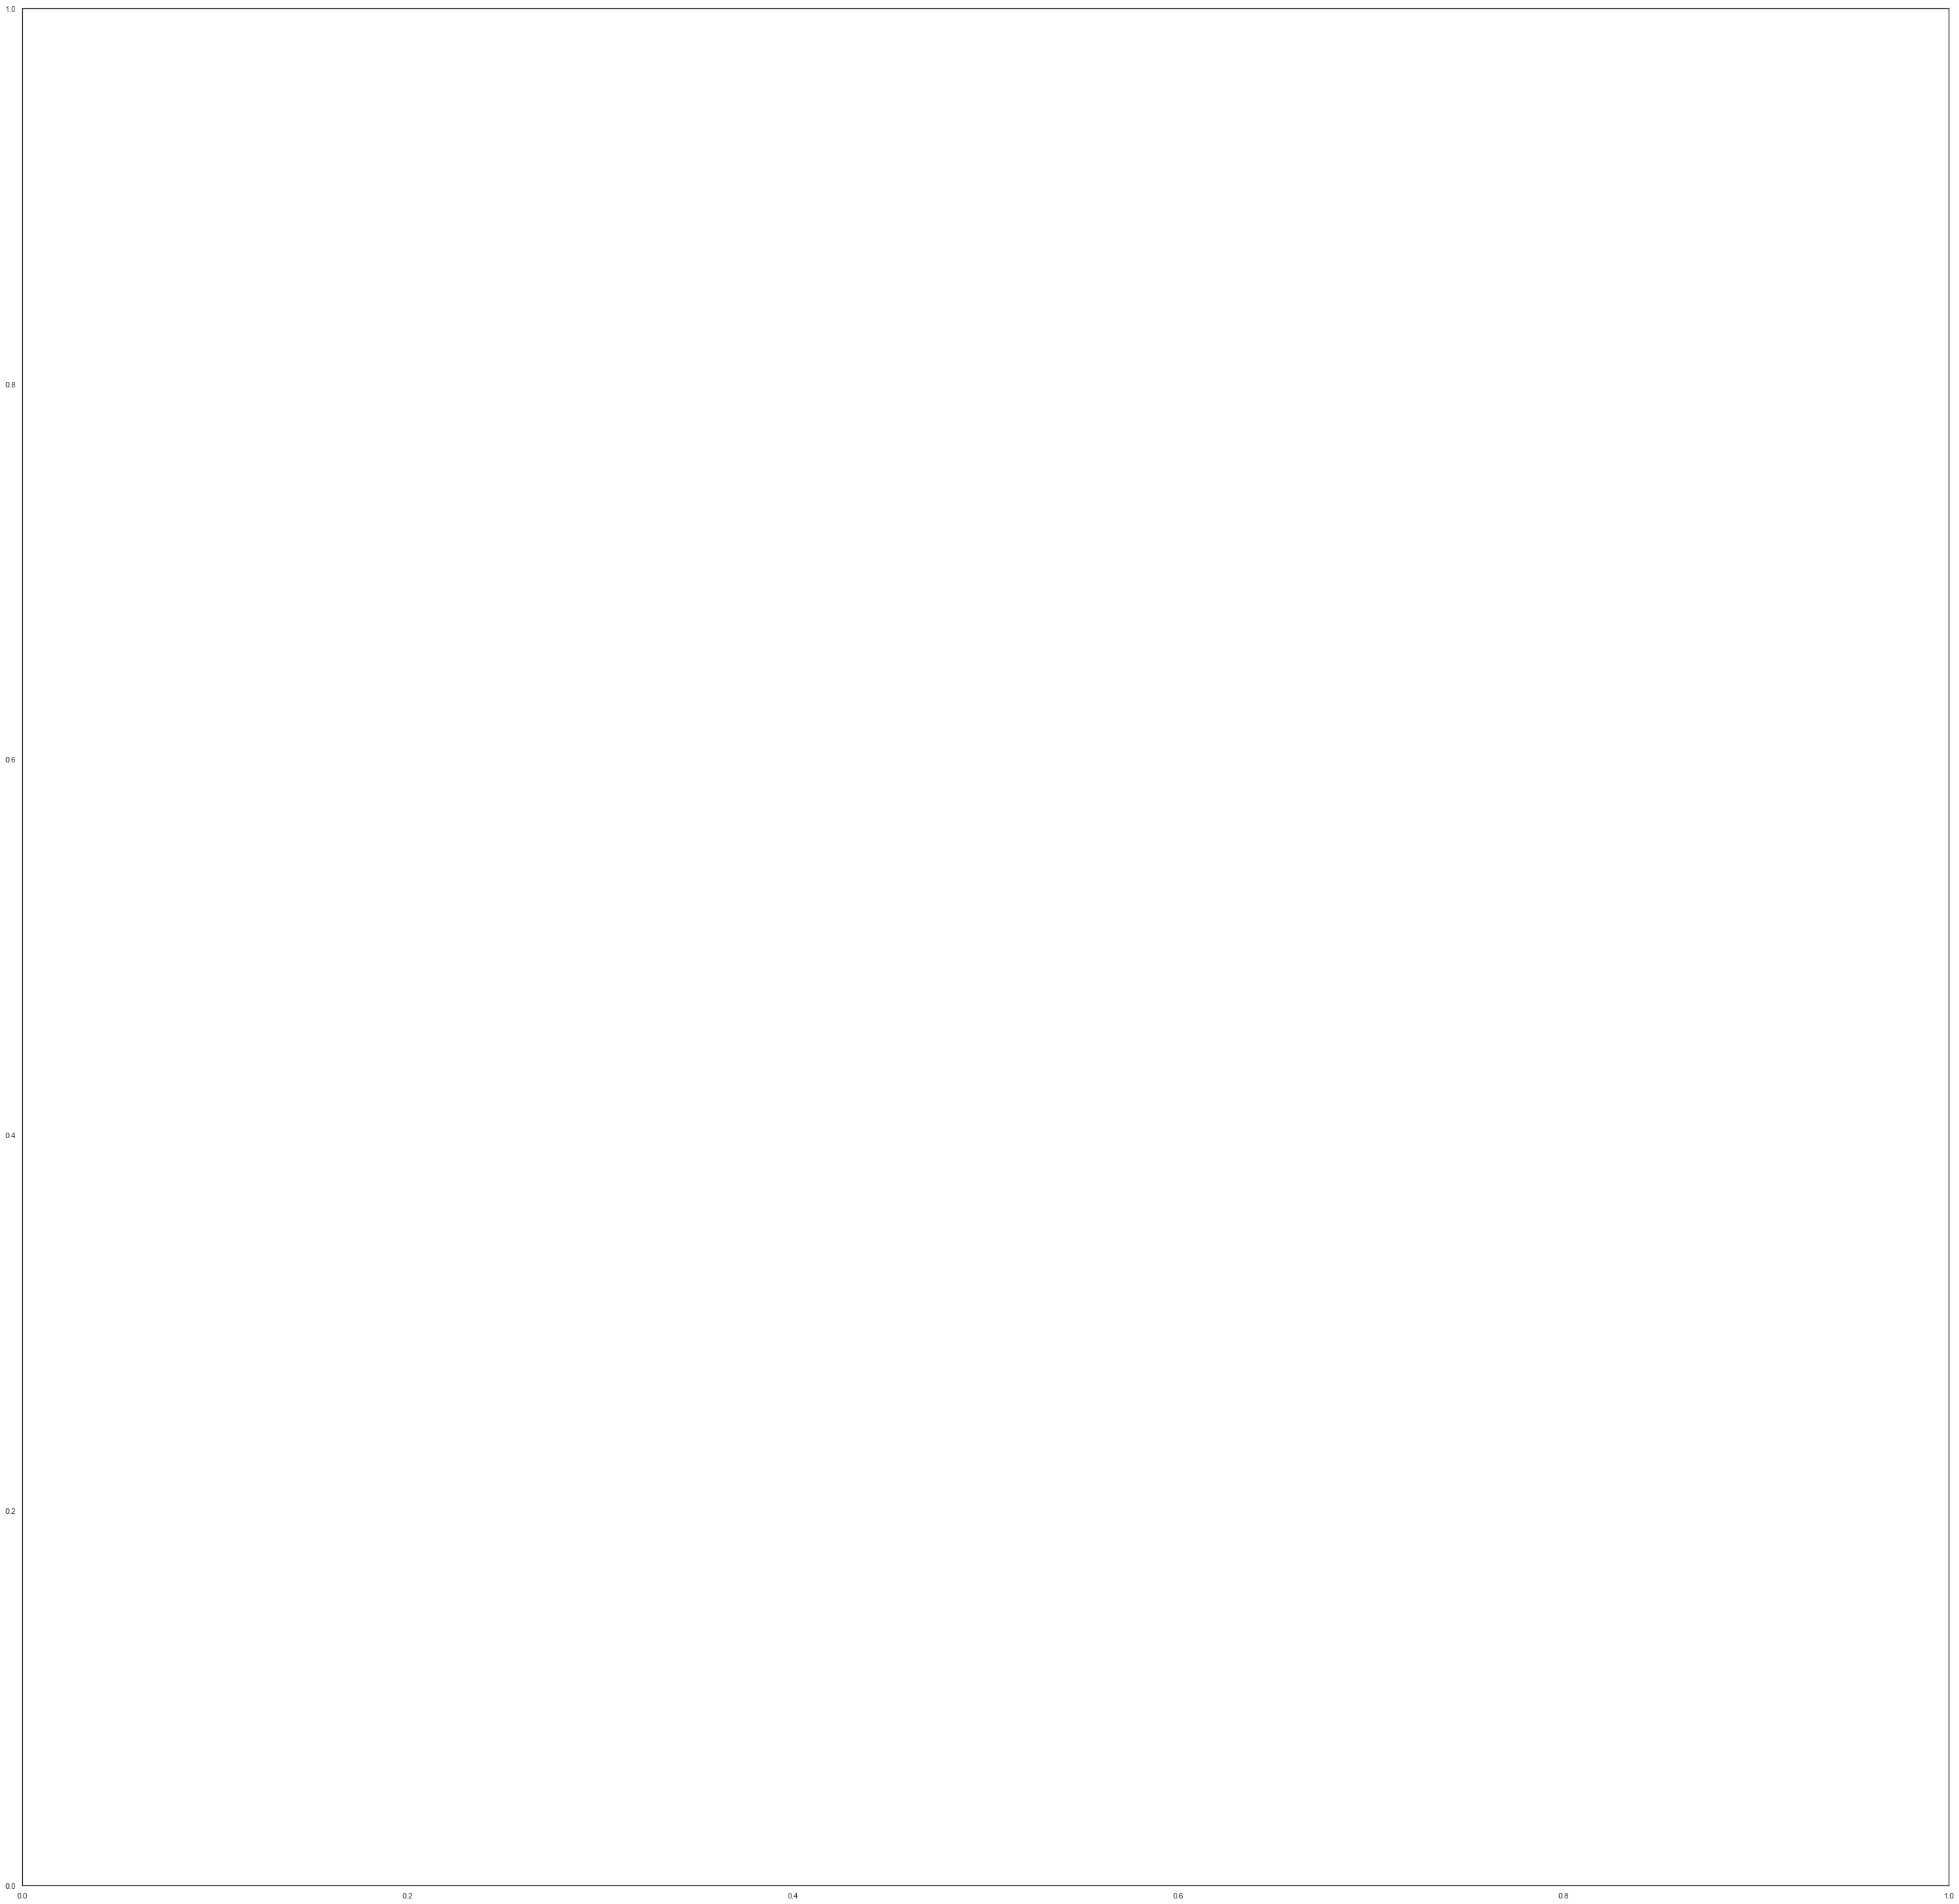

In [13]:
plt.hist(hada.ravel())

/usr/local/share/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


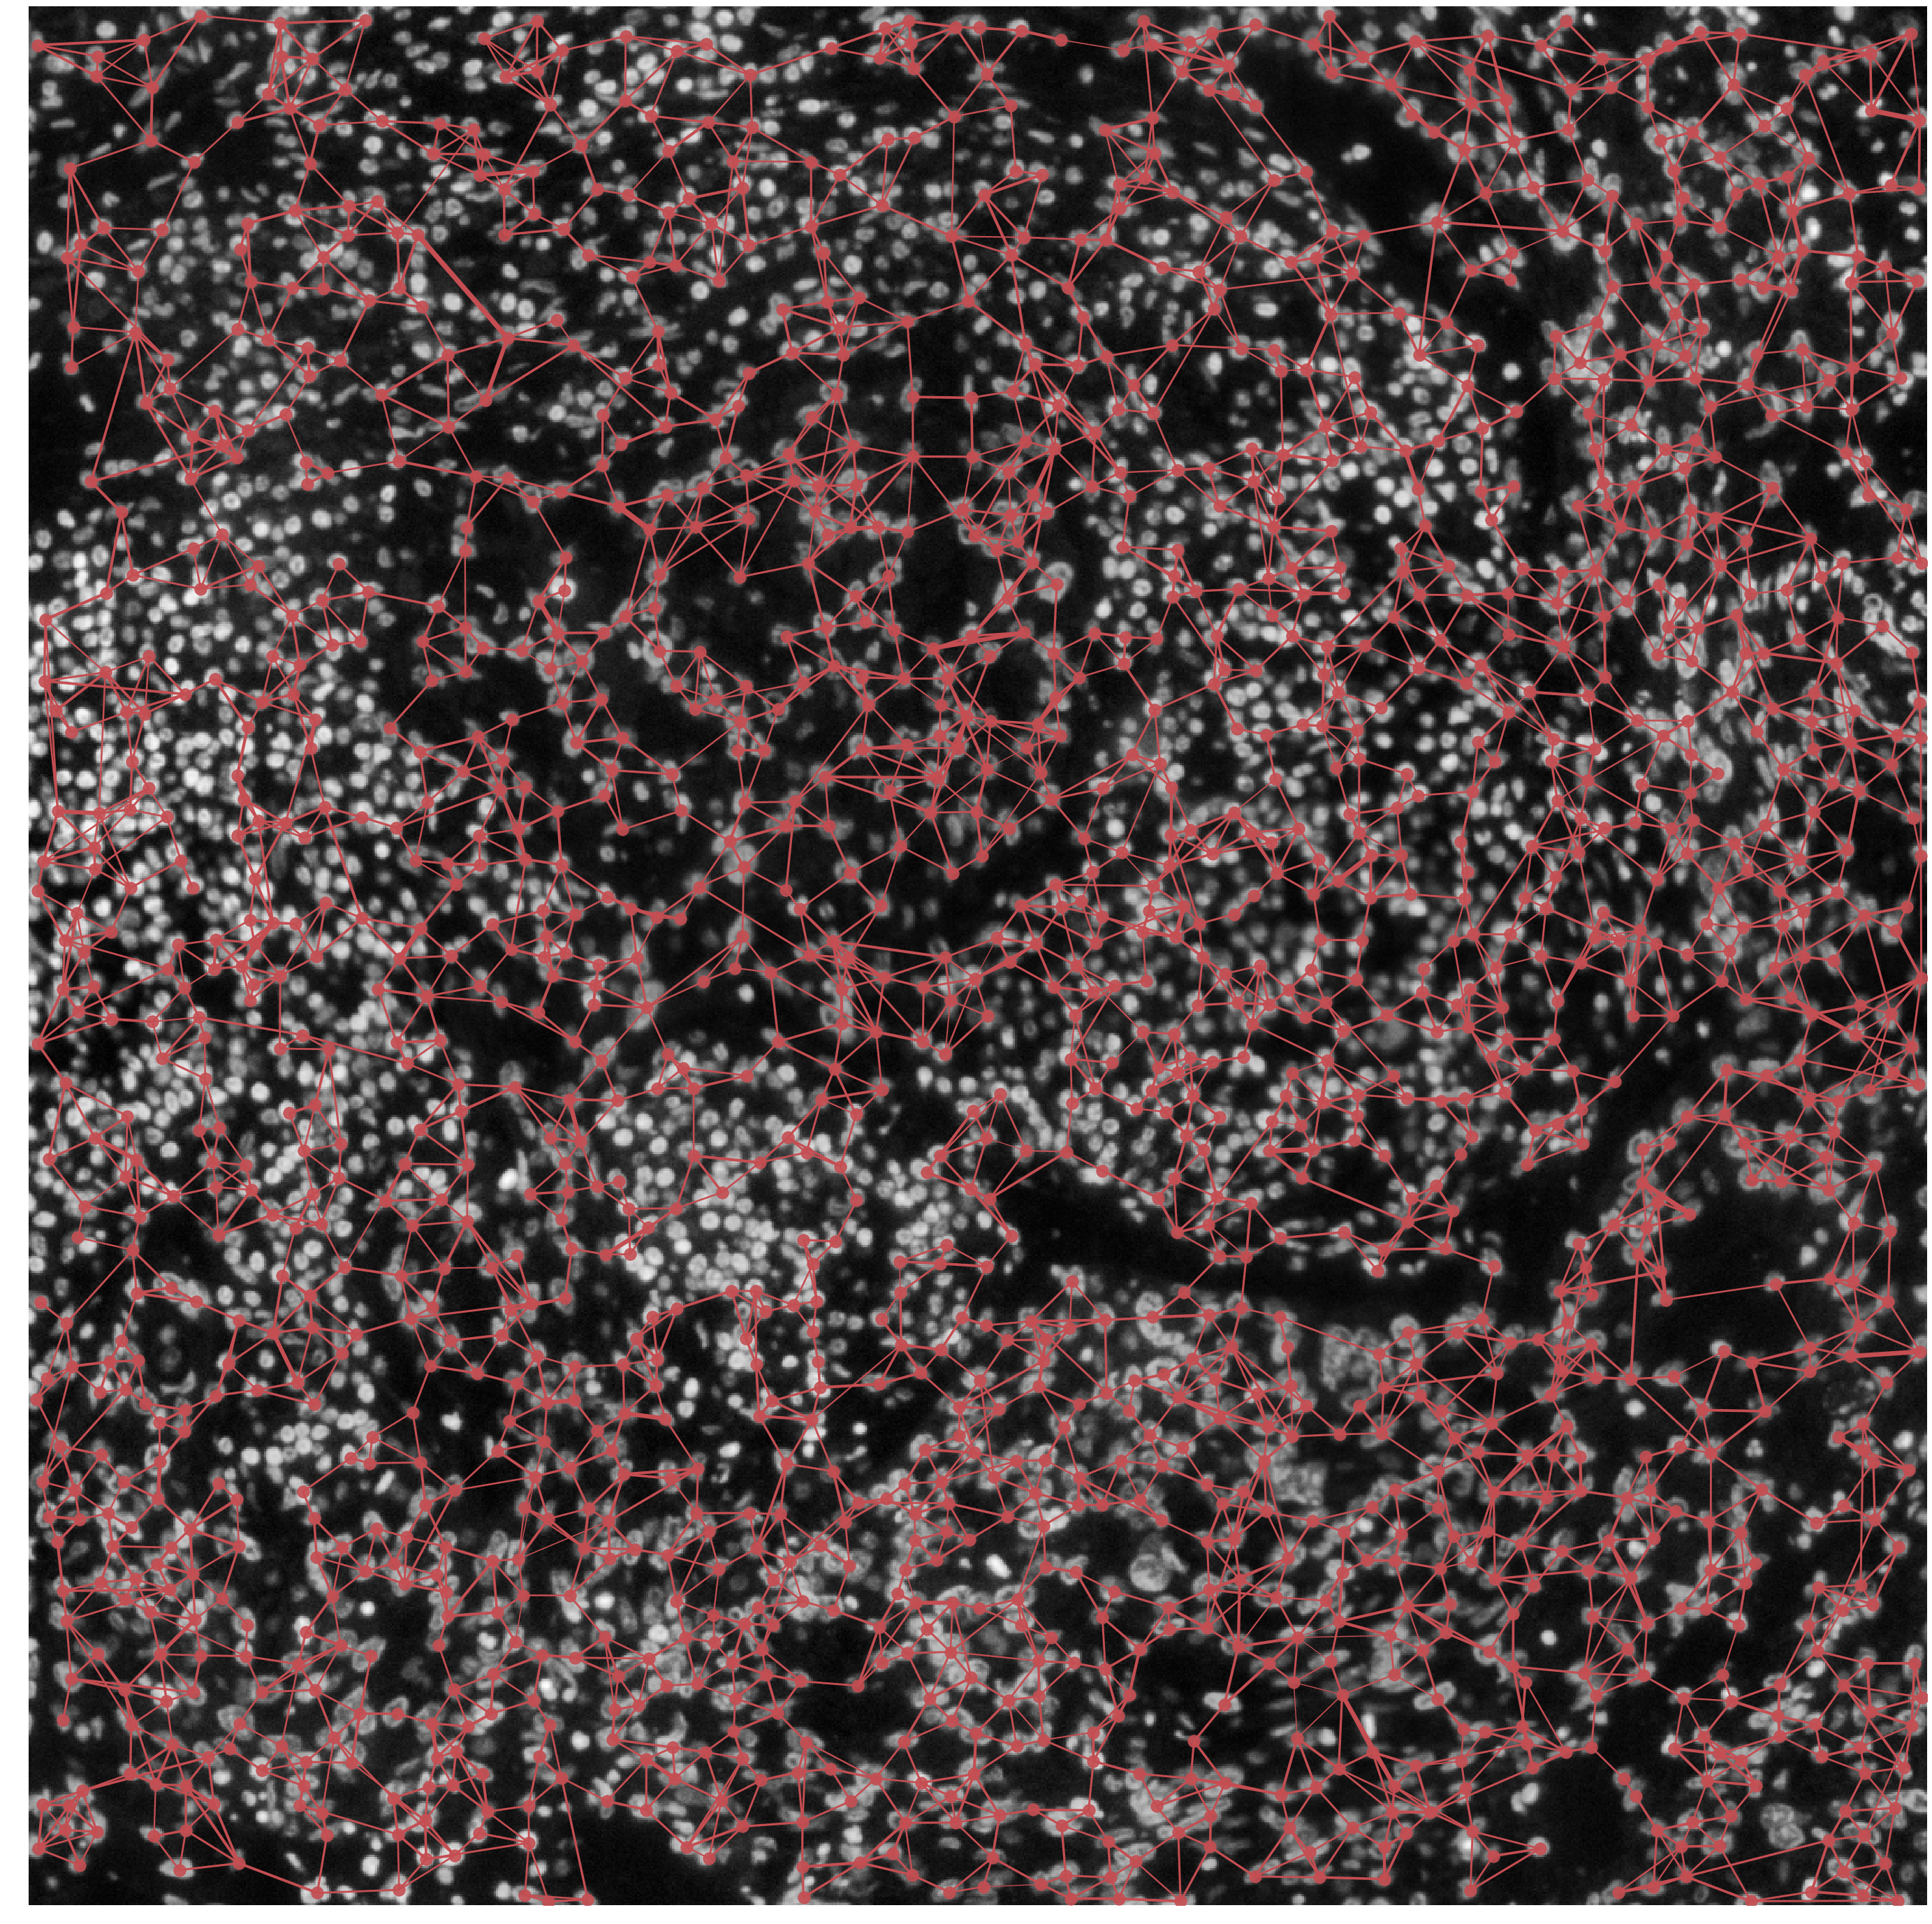

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import networkx as nx
sns.set(style='white', rc={'figure.figsize':(50,50)})

# G = nx.from_scipy_sparse_matrix(hada)
G = nx.from_numpy_array(hada)
eset = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 4]
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
# weights = [5 for a_ in weights if a_ > 5 ]
pos = XY

nx.draw_networkx_nodes(G, pos,alpha=0.9)
nx.draw_networkx_edges(G, pos, edgelist=eset,alpha=1.0, width=weights,edge_color='r')
# nx.draw_networkx_edges(G, pos, edgelist=esmall,width=6, alpha=0.5, edge_color='b', style='dashed')
# nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
plt.axis('off')

img = cv2.imread('/home/garner1/Work/dataset/cellImages/image52/equalised_iMS266_20190426_001.sub52.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
from node2vec import Node2Vec

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G, dimensions=2, walk_length=20, num_walks=200, workers=24)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)

embedding = np.asarray([model.wv[key] for idx, key in enumerate(model.wv.vocab)])

Computing transition probabilities: 100%|██████████| 1699/1699 [00:03<00:00, 506.46it/s]


In [76]:
'''
HDBSCAN clusters in 3D
low min sample size seems to refuce unclustered data;
larger min cluster size decrease cluster numbers
PCA reduction might not be a good idea because shape space is non-linear and the linear reduction could distort distances and later clustering
'''
%time labels = hdbscan.HDBSCAN(min_samples=50,min_cluster_size=100).fit_predict(embedding)

import plotly.graph_objects as go

fig = go.Figure()
size = 1
for cluster in list(set(labels))[:-1]:
    clustered = (labels == cluster)
    fig.add_trace(go.Scatter3d(
        x=embedding[clustered,0],  # <-- Put your data instead
        y=embedding[clustered,1],  # <-- Put your data instead
        z=embedding[clustered,2],  # <-- Put your data instead
        name="cluster "+str(cluster),
        mode="markers",
        marker=dict(color=cluster+1,size=1, opacity=0.5)
    ))
fig.update_layout(title_text="HDBSCAN clusters in 3D ",title_font_size=30)
fig.show()
##########
clustered = (labels >= 0)
print('The percentage of clustered data points is '+str(np.sum(clustered) *1.0/ X.shape[0]*100)+'%')


CPU times: user 381 ms, sys: 16.2 ms, total: 397 ms
Wall time: 395 ms


The percentage of clustered data points is 68.52000000000001%


In [77]:
'''Classification report for unsupervised clustering'''
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(embedding,labels,stratify=labels,random_state=42)

# Create a classifier
# classifier = svm.SVC(gamma=0.001)
classifier = KNeighborsClassifier(n_jobs=-1)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(predicted, y_test)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(predicted, y_test))

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'):
              precision    recall  f1-score   support

          -1       0.85      0.90      0.88      1119
           0       0.95      0.94      0.95      1932
           1       0.95      0.89      0.92        44
           2       0.94      0.88      0.91       406
           3       0.99      0.98      0.99       249

   micro avg       0.92      0.92      0.92      3750
   macro avg       0.94      0.92      0.93      3750
weighted avg       0.93      0.92      0.92      3750


Confusion matrix:
[[1006   86    2   23    2]
 [ 117 1815    0    0    0]
 [   5    0   39    0    0]
 [  48    0    0  358    0]
 [   4    0    0    0  245]]


In [78]:
import string 

def nochar(blabla):
    all = string.maketrans('','')
    nodigs = all.translate(all, string.digits)
    return blabla.translate(all, nodigs)

cell_ok = [-1]*len(cell_labels)
ind = 0
count_unique_cells = 0
image_ids = []
for cell in cellList:
    path = os.path.join(directory, cell)
    for img in imgLists[count_unique_cells]:
        filename = os.path.join(path, img)
        img = imageio.imread(filename)
        rmin, rmax, cmin, cmax = bbox(img)
        delta_w, delta_h = Mwidths-(rmax-rmin), Mheights-(cmax-cmin)
        image_ids.append(int(nochar(filename.split('/')[-2]))+1) #number cells adding 1 because id start from 0 on disk storage
        if delta_w >= 0:
            if delta_h >= 0:
                cell_ok[ind] = 1
        ind += 1
    count_unique_cells += 1

List = zip(image_ids,list(labels))

from collections import defaultdict
d = defaultdict(list)

for k, v in List: 
    d[k].append(v) #group the cluster_id by cell_id

from collections import Counter
cluster_single_id = []
for List in d.values():
    c = Counter(List)
    cluster_single_id.append(c.most_common(1)[0][0]) #these are sorted by cell_id value from 1 to numb_new_cells

clustered = (np.asarray(cluster_single_id)>=0)

In [79]:
import csv
with open('/home/garner1/Work/dataset/cellImages/image52/properties.csv', 'r') as f:
    properties = list(csv.reader(f, delimiter=','))
properties = np.array(properties)

fig = go.Figure()
print list(set(labels))[:-1]
for cluster in list(set(labels))[:-1]:
    clustered = (np.asarray(cluster_single_id)==cluster)
    cell_selection = np.asarray([d.keys()[ind] for ind in range(len(clustered)) if clustered[ind]])
    cluster_selection = np.asarray([d.values()[ind] for ind in range(len(clustered)) if clustered[ind]])
    if len(cell_selection) > 0:
        fig.add_trace(go.Scatter(
            x=properties[cell_selection,1].astype(np.float),  # <-- Put your data instead
            y=properties[cell_selection,2].astype(np.float),  # <-- Put your data instead
            name="cluster "+str(cluster),
            mode="markers",
            marker=dict(color=cluster+1,size=10, opacity=0.5)
        ))
fig.update_layout(title_text="Reduction in 3D ",title_font_size=30,template="plotly_white")

fig.show()

[0, 1, 2, 3]
